In [2]:
%matplotlib inline
import missingno as msno
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
from google.colab import drive # gdrive 연동
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/aiffel_data/Hackerton_2/data_dis_vs_nor.csv', encoding='cp949')
df

,SEX,BTH_G,SBP,DBP,FBS,BMI,Dis
0,0,1,116,78,94,16.6,0
1,0,1,100,60,79,22.3,0
2,0,1,100,60,87,21.9,0
3,0,1,111,70,72,20.2,0
4,0,1,120,80,98,20.0,0
...,...,...,...,...,...,...,...
999995,1,27,120,70,81,23.1,1
999996,1,27,110,70,104,27.2,1
999997,1,27,115,53,110,25.2,1
999998,1,27,120,70,90,19.7,1


In [5]:
df.notnull().sum()

SEX      1000000
BTH_G    1000000
SBP      1000000
DBP      1000000
FBS      1000000
BMI      1000000
Dis      1000000
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 7 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   SEX     1000000 non-null  int64  
 1   BTH_G   1000000 non-null  int64  
 2   SBP     1000000 non-null  int64  
 3   DBP     1000000 non-null  int64  
 4   FBS     1000000 non-null  int64  
 5   BMI     1000000 non-null  float64
 6   Dis     1000000 non-null  int64  
dtypes: float64(1), int64(6)
memory usage: 53.4 MB


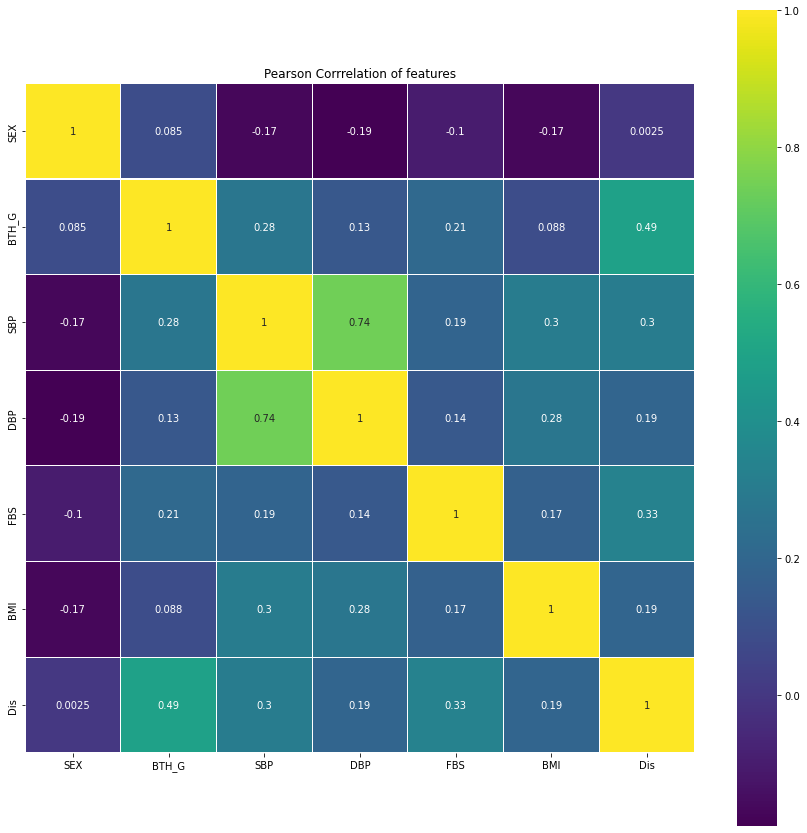

In [7]:
colormap = plt.cm.viridis # pearson 상관 계수 확인 ---> heatmap
plt.figure(figsize=(15,15))
plt.title("Pearson Corrrelation of features")
sns.heatmap(df.corr(), cmap=colormap, annot=True, linewidths=0.1, vmax=1.0, 
            square=True, linecolor='white')

수축기 혈압(SBP)와 이완기 혈압(DBP)의 상관관계는 0.74가 나왔고 나머지 데이터에서는 유의미함을 발견하지 못함

질병과 birthday 도 0.49의 상관관계가 나옴 (나이가 들수록 질병이 잘 걸린다.)

In [8]:
# split data

from sklearn.model_selection import train_test_split

# 전체 데이터 split
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, df.columns != 'Dis'],df['Dis'],  stratify=df['Dis'], shuffle=True, test_size=0.9, random_state=11)

# 
X_test,X_val,y_test,y_val=train_test_split(X_test,y_test,test_size=0.9, shuffle=True) # validation은 사용하지 않음


print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(100000, 6)
(100000,)
(810000, 6)
(810000,)
(90000, 6)
(90000,)


In [9]:
X_train.shape

(100000, 6)

In [10]:
X_test.shape

(90000, 6)

In [11]:
y_train.shape

(100000,)

In [12]:
y_test.shape

(90000,)

In [13]:
from sklearn.svm import SVC

svc = SVC().fit(X_train,y_train) # default값 1

print("train score : {}".format(svc.score(X_train, y_train)))

predict_y = svc.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, svc.predict(X_test)))
print("test score : {}".format(svc.score(X_test, y_test)))

train score : 0.82128
              precision    recall  f1-score   support

           0       0.84      0.93      0.89     66739
           1       0.72      0.50      0.59     23261

    accuracy                           0.82     90000
   macro avg       0.78      0.71      0.74     90000
weighted avg       0.81      0.82      0.81     90000

test score : 0.8203888888888888


train, test score 0.8이상으로 성능이 괜찮음

In [14]:
print(confusion_matrix(y_test, predict_y))


[[62314  4425]
 [11740 11521]]


In [15]:
# due to overfitting the test accuracy is very less as compared to the training accuracy.
#SVM requires all the features to be on a similar scale. We will need to rescale our data that all the features are approximately on the same scale and than see the performance
#Scale the data points using MinMaxScaler

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.fit_transform(X_test)

In [16]:
# Now fit the model on scaled data and precdict

svc = SVC()
svc.fit(scaled_X_train, y_train)

print("Accuracy on training set: {:.2f}".format(svc.score(scaled_X_train, y_train)))
print("Accuracy on test set: {:.2f}".format(svc.score(scaled_X_test, y_test)))

Accuracy on training set: 0.82
Accuracy on test set: 0.82


하이퍼 파라미터 조정해야 할 부분 : c값이 너무 크면 돌아가지 않음

그리드 서치나 랜덤 서치에서 한계가 있음.

default값으로 돌리고 다른 모델과의 비교를 해야할꺼 같음

In [17]:
# Scaling the data made a huge difference.But now we are actually in an underfitting regime, where training and test set performance are quite similar but less close to 100% accuracy.
# change C or gamma to fit a more complex model.

# C의 기본값은 1인데, 1000으로 했을때 실행이 되지 않음.

# try C = 10
svc = SVC(C=10)
svc.fit(scaled_X_train, y_train)

print("Accuracy on training set: {:.2f}".format(svc.score(scaled_X_train, y_train)))
print("Accuracy on test set: {:.2f}".format(svc.score(scaled_X_test, y_test)))

Accuracy on training set: 0.82
Accuracy on test set: 0.82


In [18]:

# try for C=50

svc = SVC(C=50)
svc.fit(scaled_X_train, y_train)

print("Accuracy on training set: {:.2f}".format(svc.score(scaled_X_train, y_train)))
print("Accuracy on test set: {:.2f}".format(svc.score(scaled_X_test, y_test)))

Accuracy on training set: 0.82
Accuracy on test set: 0.82


In [19]:
# Use smart way of finding the optimum value of C and kernel value for the optimum accuracy.
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC 
import numpy as np
# Use smart way of finding the optimum value of C and kernel value for the optimum accuracy.
import multiprocessing

param_grid = [
                {'kernel':['rbf', 'linear', 'poly', 'sigmoid'],
                'C':[10,100,200,300,400,500,600,700,800,900,1000] 
                }
            ]

In [20]:
grid_search = GridSearchCV(estimator=SVC(), param_grid=param_grid, scoring='accuracy', cv=10, n_jobs=multiprocessing.cpu_count() )


In [21]:
grid_search.fit(scaled_X_train, y_train)


KeyboardInterrupt: ignored

In [ ]:
grid_search.best_estimator_


In [ ]:
grid_search.best_score_


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=['normal', 'abnormal']))


y_pred = svc.predict(X_test)

print(classification_report(y_test, y_pred, target_names=['Dis']))